In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install explainerdashboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 14.8 MB/s 
     |████████████████████████████████| 133 kB 94.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=15794ff3fc47be411565d7a5cfbfc6e0bee688877bd89107d4e10c6e8150bb6a
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import shap

import utils_pack
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/final_df.tsv')
meta_data = df[['Status 3S', 'Status J', 'Date', 'Nom Commercial', 'NUMCAMPAGNE']]
df.drop(['PARAM4', 'PARAM5', 'Status 3S', 'Status J', 'Date', 'Nom Commercial', 'NUMCAMPAGNE'], axis=1, inplace=True)

In [ ]:
seed = 42

X = df.drop(['label'], axis=1)
Y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.10,
                                                    stratify = Y,
                                                    random_state=0)
# fill the data
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

# label encoder 
encoder = ce.cat_boost.CatBoostEncoder(random_state=seed)
x_train = encoder.fit_transform(X_train, y_train)
x_test = encoder.transform(X_test)


# data augmentation
x_res, y_res = SMOTE(sampling_strategy= 0.9891644658212434,
                     random_state=seed).fit_resample(x_train, y_train)

# scale the data
scaler = MinMaxScaler()
scalre_x_train = scaler.fit_transform(x_res)
scalre_x_test = scaler.transform(x_test)

scalre_x_train = pd.DataFrame(scalre_x_train, index=x_res.index, columns=x_train.columns)
scalre_x_test = pd.DataFrame(scalre_x_test, index=x_test.index, columns=x_test.columns)

**Model load**

In [ ]:
import pickle
filename = '/content/drive/MyDrive/finalized_model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
predictions = loaded_model.predict(scalre_x_test)
predictions_proba =  loaded_model.predict_proba(scalre_x_test)

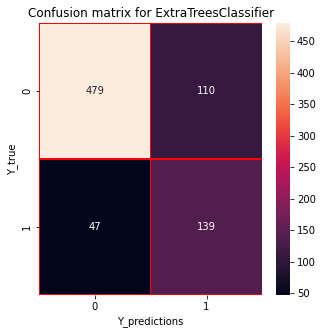


Accuracy: 0.797419
Precision: 0.558233
Recall: 0.747312
F1 score: 0.639080
roc_auc score: 0.780277


In [ ]:
utils_pack.confusion_matrix_graph(loaded_model, predictions, y_test)

In [ ]:
from eli5.sklearn import PermutationImportance
import eli5

perm = PermutationImportance(loaded_model, n_iter=12, scoring='f1').fit(scalre_x_test, y_test)
res = eli5.show_weights(perm, top=60, feature_names = x_test.columns.tolist())
res

Weight,Feature
0.0426 ± 0.0247,PRODUCT_TYPE
0.0216 ± 0.0152,POIDSTP11
0.0163 ± 0.0073,NIVEAUSILO83
0.0154 ± 0.0097,TEMPEXT
0.0150 ± 0.0055,POIDSTP5
0.0142 ± 0.0118,NIVEAUSILO5
0.0121 ± 0.0121,POIDSTP1
0.0118 ± 0.0119,NIVEAUSILO6
0.0109 ± 0.0120,TEMPMEL_AVG
0.0107 ± 0.0078,POIDSTP6


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(scalre_x_train)
scalre_x_test['category'] = kmeans.predict(scalre_x_test)

**Error analysis**

In [ ]:
df_analysis = pd.DataFrame({
                     'actual': y_test,
                      'prediction':predictions,
                     'proba out of spec': list(map(lambda x:round((x[1]*100), 2),
                                         predictions_proba.tolist())),
                     'proba good product': list(map(lambda x:round((x[0]*100), 2),
                                         predictions_proba.tolist())),
                     'porduct_name': meta_data['Nom Commercial'][scalre_x_test.index],
                     'NUMCAMPAGNE': meta_data['NUMCAMPAGNE'][scalre_x_test.index],
                      'Status J	': meta_data['Status J'][scalre_x_test.index],
                      'Status 3S': meta_data['Status 3S'][scalre_x_test.index],
                      'unsupervised': scalre_x_test['category'],
                      'Date': meta_data['Date'][scalre_x_test.index]})

df_analysis['correctness'] = np.where(df_analysis['actual'] == df_analysis['prediction'], 'correct', 'uncorrect')
df_analysis['proba_diff'] = abs(df_analysis['proba good product'] - df_analysis['proba out of spec'])

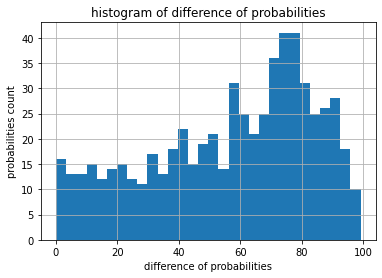

In [ ]:
df_analysis[df_analysis['correctness'] == 'correct'].sort_values('proba_diff', ascending=True)['proba_diff'].hist(bins=30)
plt.title('histogram of difference of probabilities')
plt.xlabel('difference of probabilities')
plt.ylabel('probabilities count')
plt.show()

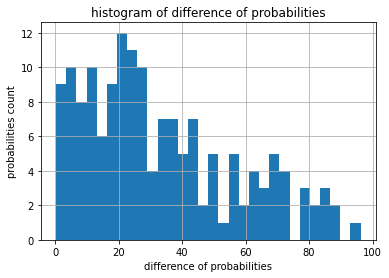

In [ ]:
df_analysis[df_analysis['correctness'] == 'uncorrect'].sort_values('proba_diff', ascending=True)['proba_diff'].hist(bins=30)
plt.title('histogram of difference of probabilities')
plt.xlabel('difference of probabilities')
plt.ylabel('probabilities count')
plt.show()

In [ ]:
df1 = pd.DataFrame(df_analysis[df_analysis['correctness'] == 'uncorrect']['porduct_name'].value_counts()).reset_index()
df2 = pd.DataFrame(df_analysis[df_analysis['correctness'] == 'correct']['porduct_name'].value_counts()).reset_index()
df3 = meta_data['Nom Commercial'][x_train.index].value_counts().reset_index()

df_analyse_per_product = pd.merge(df1, df2, on='index', suffixes=['_uncorrect', '_correct'], how='outer')
df_analyse_per_product = pd.merge(df_analyse_per_product, df3, on='index', how='outer')

df_analyse_per_product = df_analyse_per_product.fillna(0)
df_analyse_per_product['ratio1'] = (df_analyse_per_product['porduct_name_uncorrect'] / (df_analyse_per_product['porduct_name_uncorrect']+df_analyse_per_product['porduct_name_correct']))*100
df_analyse_per_product['ratio2'] = (df_analyse_per_product['porduct_name_uncorrect'] / df_analyse_per_product['Nom Commercial'])*100


In [ ]:
df_analyse_per_product.sort_values('Nom Commercial', ascending=False)

,index,porduct_name_uncorrect,porduct_name_correct,Nom Commercial,ratio1,ratio2
0,CALDE® TAP HIFLEX 11 FOS,32.0,49.0,807,6.071871,3.965304
2,CALDE® TAP TL 1040,11.0,74.0,793,9.331652,1.387137
5,CALDE® TAP 321 BQH,8.0,62.0,599,10.350584,1.335559
1,CALDE® TAP 017 FASX,23.0,45.0,555,8.108108,4.144144
4,CALDE® TAP 335 CMS,9.0,55.0,526,10.456274,1.711027
3,CALDE® TAP 344 CEMH-G2,10.0,35.0,387,9.043928,2.583979
7,CALDE® TAP 336 CM,6.0,32.0,366,8.743169,1.639344
28,CALDE® TAP 341 CEM,1.0,22.0,286,7.692308,0.349650
11,CALDE® TAP 339 BEX,4.0,38.0,271,14.022140,1.476015
16,CALDE® TAP 341/2 CEM,2.0,28.0,196,14.285714,1.020408


In [ ]:
df_analysis[df_analysis['unsupervised'] == 0].sort_values('proba_diff', ascending=True)

,actual,prediction,proba out of spec,proba good product,porduct_name,NUMCAMPAGNE,Status J\t,Status 3S,unsupervised,Date,correctness,proba_diff
5661,0,1,50.18,49.82,CALDE® TAP 017 FASX,2466390,ok,ok,0,2021-10-28 00:00:00,uncorrect,0.36
6149,1,1,50.20,49.80,Calde Tap 341 CES,2328800,ac,NaN,0,2021-06-24 00:00:00,correct,0.40
7400,0,0,49.71,50.29,CALDE® TAP 321 BQH,2658740,ok,NaN,0,2022-06-24 00:00:00,correct,0.58
2166,0,0,49.54,50.46,CALDE® TAP 344 CEMH-G2,2502000,ok,ok,0,2022-01-24 00:00:00,correct,0.92
833,1,0,49.50,50.50,CALDE® TAP 336/4 BEX,2265230,ok,recyclage,0,2021-02-24 00:00:00,uncorrect,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0,0,1.43,98.57,CALDE® TAP HIFAST 12 HKM,2536510,ok,ok,0,2022-02-11 00:00:00,correct,97.14
4922,0,0,1.42,98.58,CALDE® TAP TL 1040,2461220,ac,ok,0,2022-02-14 00:00:00,correct,97.16
3443,0,0,1.41,98.59,CALDE® TAP 321 BQH,2172110,ok,ok,0,2020-09-25 00:00:00,correct,97.18
6021,0,0,1.38,98.62,CALDE® TAP OPTI 73 UKR,2322180,ok,ok,0,2021-06-03 00:00:00,correct,97.24


In [ ]:
df_analysis[df_analysis['correctness'] == 'correct'].sort_values('proba_diff', ascending=True)

,actual,prediction,proba out of spec,proba good product,porduct_name,NUMCAMPAGNE,Status J\t,Status 3S,unsupervised,Date,correctness,proba_diff
1907,0,0,49.95,50.05,CALDE® TAP 344 CEMH-G2,2579260,ok,ok,1,2022-06-16 00:00:00,correct,0.10
6149,1,1,50.20,49.80,Calde Tap 341 CES,2328800,ac,NaN,0,2021-06-24 00:00:00,correct,0.40
7400,0,0,49.71,50.29,CALDE® TAP 321 BQH,2658740,ok,NaN,0,2022-06-24 00:00:00,correct,0.58
5825,1,1,50.34,49.66,CALDE® TAP 017 FASX,2573600,ac,hors spec,1,2022-06-02 00:00:00,correct,0.68
2166,0,0,49.54,50.46,CALDE® TAP 344 CEMH-G2,2502000,ok,ok,0,2022-01-24 00:00:00,correct,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0,0,1.43,98.57,CALDE® TAP HIFAST 12 HKM,2536510,ok,ok,0,2022-02-11 00:00:00,correct,97.14
4922,0,0,1.42,98.58,CALDE® TAP TL 1040,2461220,ac,ok,0,2022-02-14 00:00:00,correct,97.16
3443,0,0,1.41,98.59,CALDE® TAP 321 BQH,2172110,ok,ok,0,2020-09-25 00:00:00,correct,97.18
6021,0,0,1.38,98.62,CALDE® TAP OPTI 73 UKR,2322180,ok,ok,0,2021-06-03 00:00:00,correct,97.24


In [ ]:
df_analysis[df_analysis['correctness'] == 'uncorrect'].sort_values('proba_diff', ascending=True)

,actual,prediction,proba out of spec,proba good product,porduct_name,NUMCAMPAGNE,Status J\t,Status 3S,unsupervised,Date,correctness,proba_diff
5661,0,1,50.18,49.82,CALDE® TAP 017 FASX,2466390,ok,ok,0,2021-10-28 00:00:00,uncorrect,0.36
833,1,0,49.50,50.50,CALDE® TAP 336/4 BEX,2265230,ok,recyclage,0,2021-02-24 00:00:00,uncorrect,1.00
6376,0,1,50.64,49.36,CALDE® TAP 336/11 BEX,2426940,ok,ok,0,2021-11-16 00:00:00,uncorrect,1.28
6618,0,1,50.75,49.25,CALDE® TAP 335 CMS,2320540,ok,ok,0,2021-04-26 00:00:00,uncorrect,1.50
6404,0,1,51.17,48.83,CALDE® TAP 336/11 BEX,2450510,ok,ok,0,2022-01-06 00:00:00,uncorrect,2.34
...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,1,92.71,7.29,CALDE™ TAP 240 BEX SEV3,2217570,ok,NaN,0,2020-11-13 00:00:00,uncorrect,85.42
7162,1,0,7.15,92.85,CALDE® TAP 339/4 BEX,2511890,ac,recyclage,0,2021-12-13 00:00:00,uncorrect,85.70
7496,0,1,93.36,6.64,CALDE® TAP 336/12 BEX,2644510,ok,ok,1,2022-06-17 00:00:00,uncorrect,86.72
7227,1,0,5.68,94.32,CALDE® TAP 341/2 CEM,2551840,ac,recyclage,0,2022-02-11 00:00:00,uncorrect,88.64


In [ ]:
df_analysis[df_analysis['porduct_name'] == 'CALDE® TAP HIFLEX 11 FOS'].sort_values('proba_diff', ascending=True).head(60)

,actual,prediction,proba out of spec,proba good product,porduct_name,NUMCAMPAGNE,Status J\t,Status 3S,unsupervised,Date,correctness,proba_diff
2421,1,1,50.61,49.39,CALDE® TAP HIFLEX 11 FOS,2301350,ac,NaN,0,2021-06-16 00:00:00,correct,1.22
2403,1,0,48.66,51.34,CALDE® TAP HIFLEX 11 FOS,2367910,hors spec,NaN,0,2021-06-11 00:00:00,uncorrect,2.68
2688,0,1,51.40,48.60,CALDE® TAP HIFLEX 11 FOS,2332050,ok,NaN,0,2021-09-20 00:00:00,uncorrect,2.80
2578,0,0,47.72,52.28,CALDE® TAP HIFLEX 11 FOS,2324050,ok,ok,0,2021-08-06 00:00:00,correct,4.56
2522,1,0,47.67,52.33,CALDE® TAP HIFLEX 11 FOS,2312890,ok,recyclage,0,2021-07-12 00:00:00,uncorrect,4.66
3209,0,1,52.35,47.65,CALDE® TAP HIFLEX 11 FOS,2295450,ok,ok,0,2021-04-14 00:00:00,uncorrect,4.70
2384,0,0,47.64,52.36,CALDE® TAP HIFLEX 11 FOS,2367910,ok,ok,0,2021-06-10 00:00:00,correct,4.72
2630,1,0,46.89,53.11,CALDE® TAP HIFLEX 11 FOS,2327040,ac,NaN,0,2021-08-13 00:00:00,uncorrect,6.22
2523,0,0,46.79,53.21,CALDE® TAP HIFLEX 11 FOS,2312890,ok,NaN,0,2021-07-12 00:00:00,correct,6.42
3151,1,0,46.73,53.27,CALDE® TAP HIFLEX 11 FOS,2295600,recyclage,ok,0,2021-03-16 00:00:00,uncorrect,6.54


In [ ]:
explainer = shap.Explainer(loaded_model.predict, scalre_x_test)
sv = explainer(scalre_x_test)

Permutation explainer: 776it [39:32,  3.07s/it]


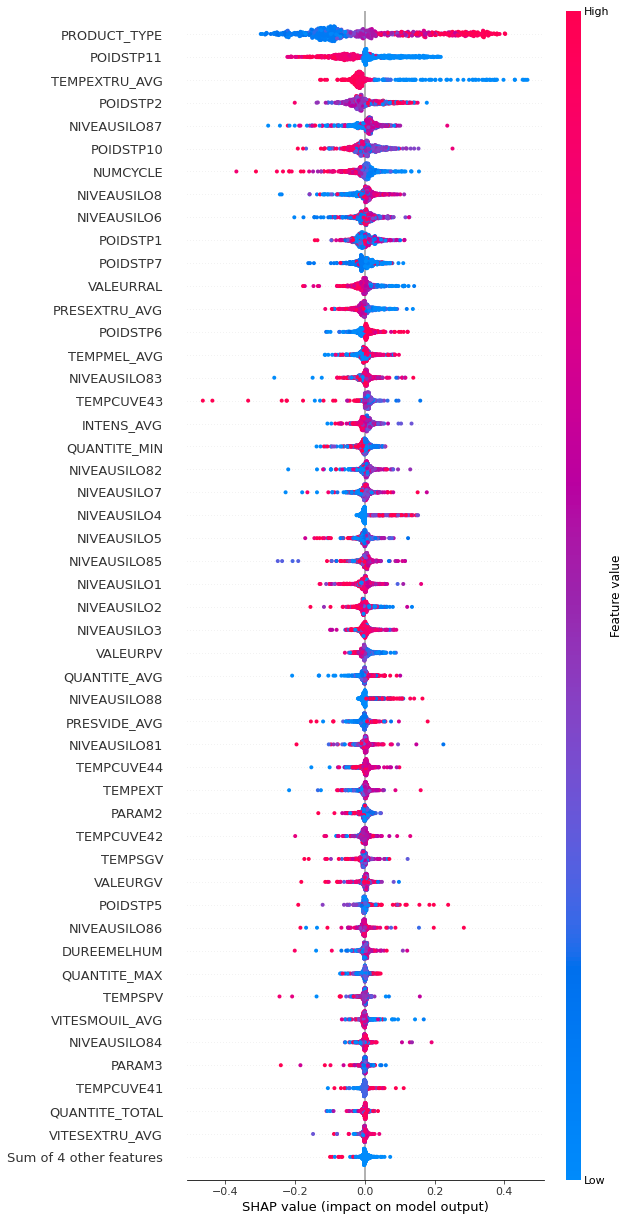

In [ ]:
shap.plots.beeswarm(sv, max_display=50)

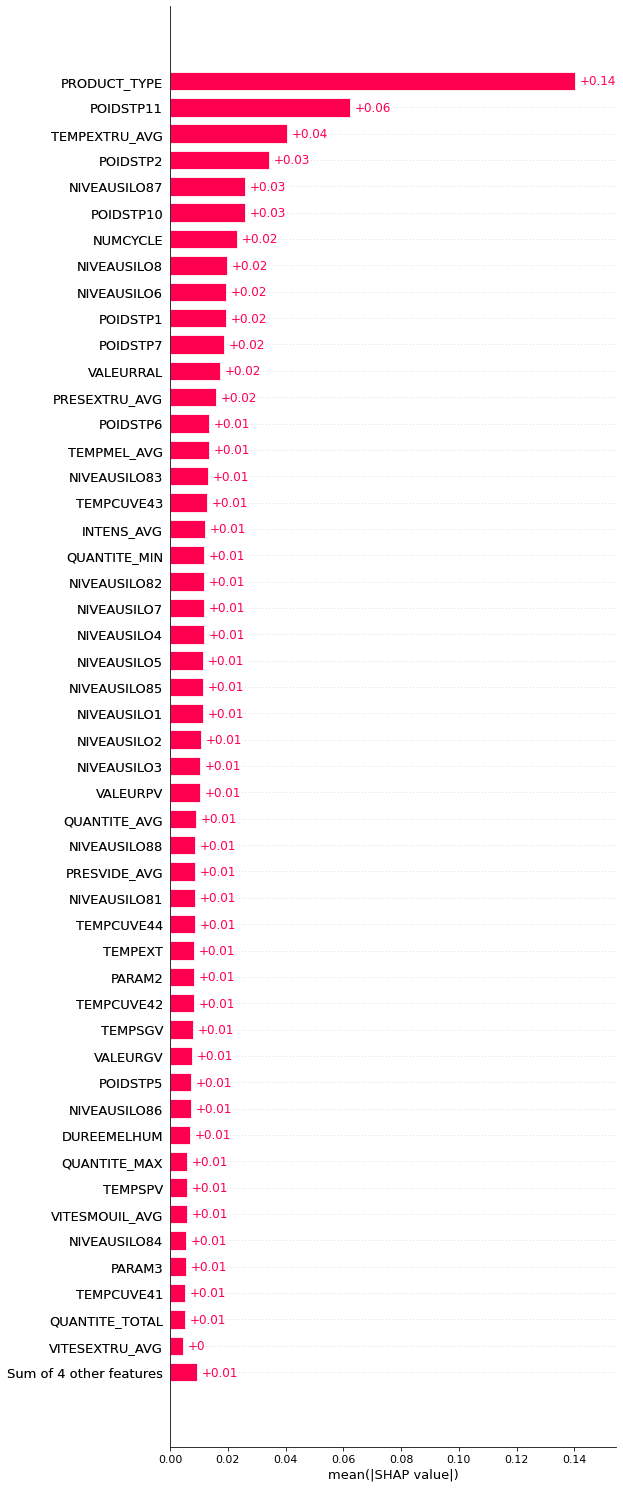

In [ ]:
shap.plots.bar(sv, max_display=50)